## Plot the Mean & Standard Deviation of The Fetal and Total Pathlength Per SDD

In [1]:
# Import Pathlength Files

from pathlib import Path
from glob import glob
import pandas as pd
import json
from tfo_sim.misc import generate_sdd_column    # Ignore the error, it is a bug in VSCode
import matplotlib.pyplot as plt
import seaborn as sns

raw_file_path = Path(r'/home/rraiyan/simulations/tfo_sim/data/dan_iccps_pencil2')

raw_files = list(raw_file_path.glob("*.pkl"))  # RAW files are in pickle format
raw_files = [Path(file) for file in raw_files]

file1 = raw_files[15]
config1 = file1.with_suffix('.json')
raw_data1 = pd.read_pickle(file1)
with open(config1) as f:
    config_data1 = json.load(f)


all_ppath_columns = list(filter(lambda x: 'ppath' in x, raw_data1.columns))
raw_data1['Total ppath'] = raw_data1[all_ppath_columns].sum(axis=1)


sdd_col = generate_sdd_column(raw_data1).astype(int)
raw_data1['SDD'] = sdd_col
all_sdd = sdd_col.unique()
all_sdd.sort()
print(all_sdd)

[10 15 19 24 28 33 37 41 46 50 55 59 64 68 72 77 81 86 90 94]


## Ridge Plots

/home/rraiyan/cybercat/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/rraiyan/cybercat/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/rraiyan/cybercat/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/rraiyan/cybercat/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/rraiya

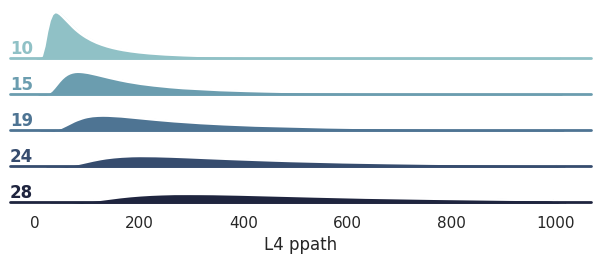

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


selected_sdd = all_sdd[:5]

ridge_data = raw_data1[['L4 ppath', 'SDD', 'Total ppath']]
ridge_data = ridge_data[ridge_data['SDD'].isin(selected_sdd)]
ridge_data = ridge_data[ridge_data['Total ppath'] < 1000]

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(len(selected_sdd), rot=-.25, light=.7)
g = sns.FacetGrid(ridge_data, row="SDD", hue="SDD", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Total ppath",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Total ppath", clip_on=False, color="w", lw=2, bw_adjust=.5)



# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "L4 ppath")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
# g.set(yscale="log")

## Individual Bar Plots

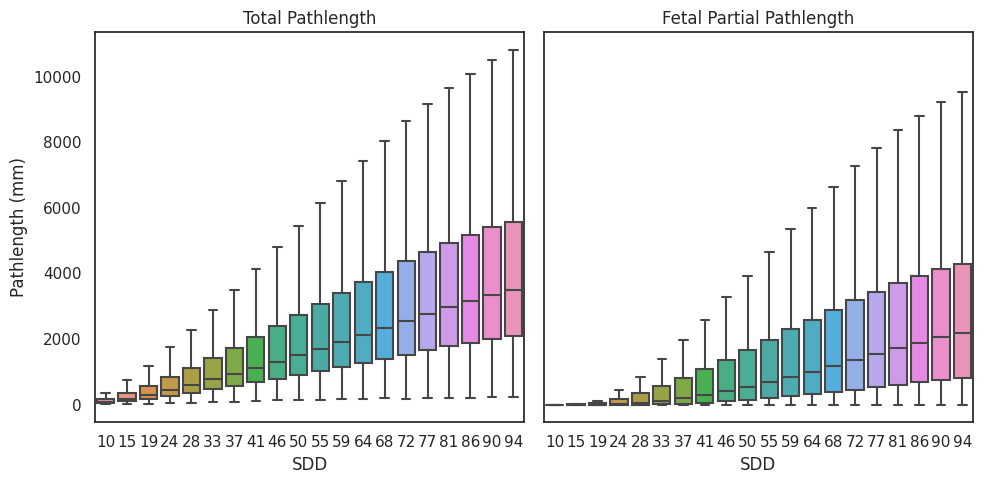

In [3]:
# Plot the Median of Total Pathlength and L4 Pathlength for each SDD
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.boxplot(x='SDD', y='Total ppath', data=raw_data1, ax=ax[0], showfliers=False)
sns.boxplot(x='SDD', y='L4 ppath', data=raw_data1, ax=ax[1], showfliers=False)
ax[0].set_title('Total Pathlength')
ax[1].set_title('Fetal Partial Pathlength')
# Remove the y-axis label from the right plot
ax[1].set_ylabel('')
ax[0].set_ylabel('Pathlength (mm)')
plt.tight_layout()
plt.show()

# Side By Side Bar Plot

<AxesSubplot:xlabel='SDD', ylabel='Length (mm)'>

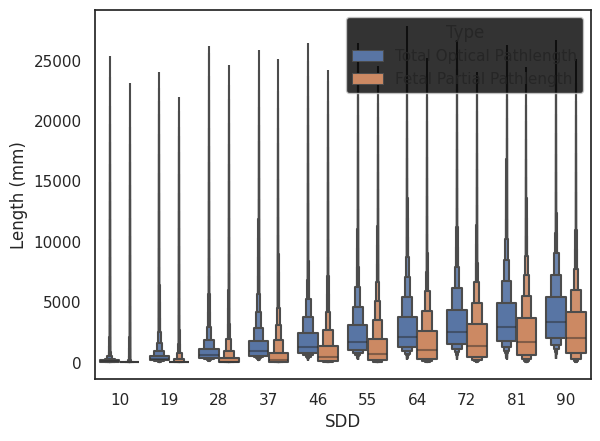

In [4]:
chosen_sdd = all_sdd[::2]
wide_frmt = raw_data1[raw_data1['SDD'].isin(chosen_sdd)]
# Rename Columns for better visualization
wide_frmt = wide_frmt.rename(columns={'Total ppath': 'Total Optical Pathlength', 'L4 ppath': 'Fetal Partial Pathlength'})
wide_frmt = wide_frmt.melt(id_vars=['SDD'], value_vars=['Total Optical Pathlength', 'Fetal Partial Pathlength'], var_name='Type', value_name='Length (mm)')
sns.boxenplot(x='SDD', y='Length (mm)', hue='Type', data=wide_frmt, showfliers=False)